In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):        ###MclAgent5
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
        self.prev_nu = 0.0       #追加
        self.prev_omega = 0.0 #追加
        
    def decision(self, observation=None): #追加
        self.mcl.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[ 0.01782765  0.00011141  0.01249789]
[ 0.01381827  0.00011994  0.01735923]
[ 0.02216567  0.00010671  0.00962794]
[ 0.02092645  0.00027414  0.02619873]
[  1.67436412e-02   9.86018865e-05   1.17776947e-02]
[ 0.01503194  0.00011199  0.0149005 ]
[ 0.01766928  0.00012432  0.01407171]
[ 0.02538076  0.00011351  0.00894421]
[  2.22704308e-02   6.60784518e-05   5.93416971e-03]
[ 0.02685272  0.00017066  0.01271033]
[ 0.02090896  0.00012576  0.01202933]
[ 0.01856511  0.00015053  0.01621605]
[ 0.02555853  0.00023817  0.01863707]
[ 0.02104424  0.00011279  0.01071951]
[ 0.01831716  0.00024012  0.02621687]
[ 0.02202801  0.00031144  0.02827449]
[  1.50606246e-02   6.97291466e-05   9.25972863e-03]
[  2.17603948e-02   6.86355695e-05   6.30828092e-03]
[ 0.0194482   0.00021607  0.0222192 ]
[ 0.02364351  0.00010588  0.00895611]
[  1.72220576e-02   5.65947986e-05   6.57233837e-03]
[  1.68824955e-02   8.55989954e-05   1.01404750e-02]
[ 0.02288619  0.00028827  0.02519056]
[ 0.02184167  0.00015459  0.01415559

<IPython.core.display.Javascript object>


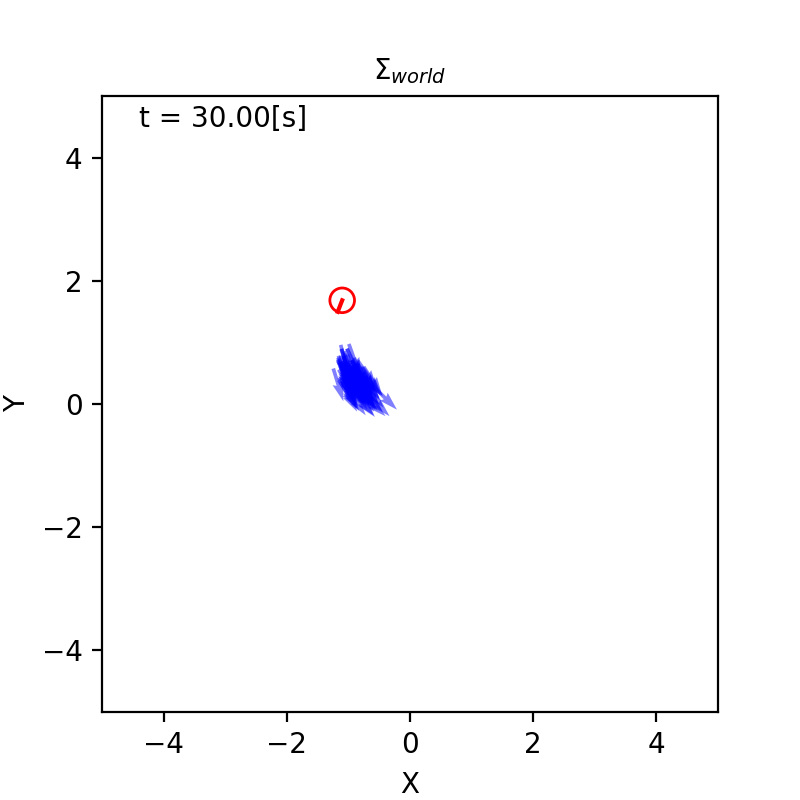

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()